# Deep Learning

##Demo - IA Generativa com Stable Diffusion

### Dr. Ahirton Lopes

# **Stable Diffusion** 🎨
*...usando `🧨diffusers`*

Stable Diffusion é um modelo de difusão latente de texto para imagem criado pelos pesquisadores e engenheiros da [CompVis](https://github.com/CompVis), [Stability AI](https://stability.ai/) e [LAION](https://laion.ai/). Ele é treinado em imagens 512x512 de um subconjunto do banco de dados LAION-5B.  

Este modelo usa um codificador de texto CLIP ViT-L/14 congelado para condicionar o modelo em prompts de texto. Com seu codificador de texto de 860M UNet e 123M, o modelo é relativamente leve e pode ser executado em muitas GPUs, mesmo os modelos voltados para consumidores comuns. Consulte o seguinte [link](https://huggingface.co/CompVis/stable-diffusion) para obter mais informações sobre o modelo.

Este notebook visa te ajudar a iniciar no uso de Stabble Diffusion via as bibliotecas 🤗 Hugging Face e [🧨 Diffusers](https://github.com/huggingface/diffusers).

Vamos começar!

## 1. Usando o `StableDiffusionPipeline`

Antes de mergulhar nos aspectos teóricos de como a difusão estável funciona,
vamos experimentar um pouco 🤗.

Nesta seção, mostro como você pode executar a inferência de texto para imagem em apenas algumas linhas de código!

### Setup

Primeiro, verifique se você está usando um ambiente de execução de GPU para executar este notebook, para que a inferência seja muito mais rápida. Se o seguinte comando falhar, use o menu `Ambiente de execução` acima e selecione `Alterar o ambiente de execução`.

In [ ]:
!nvidia-smi

Sat Apr  6 14:27:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0              44W /  70W |   5633MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Em seguida, você deve instalar as bibliotecas `diffusers` assim como `scipy`, `ftfy` e `transformers`. `accelerate` é usado para obter um carregamento muito mais rápido.

In [ ]:
!pip install diffusers==0.11.1
!pip install transformers scipy ftfy accelerate

### Pipeline Stable Diffusion

`StableDiffusionPipeline` é um pipeline de inferência de ponta a ponta que você pode usar para gerar imagens de texto com apenas algumas linhas de código.

Primeiro, carregamos os pesos pré-treinados de todos os componentes do modelo. Neste notebook usamos Stable Diffusion versão 2.1 base (https://huggingface.co/stabilityai/stable-diffusion-2-1-base), mas existem outras variantes que você pode querer experimentar:

* [runwayml/stable-diffusion-v1-5](https://huggingface.co/runwayml/stable-diffusion-v1-5)
* [stabilityai/stable-diffusion-2-1-base](https://huggingface.co/stabilityai/stable-diffusion-2-1-base)
* [stabilityai/stable-diffusion-2-1](https://huggingface.co/stabilityai/stable-diffusion-2-1).

Esta versão pode produzir imagens com resolução de 768x768, enquanto as outras trabalham em 512x512.

Além do ID do modelo [stabilityai/stable-diffusion-2-1-base](stabilityai/stable-diffusion-2-1-base), também estamos passando uma `revision` específica e `torch_dtype ` para o método `from_pretrained`.


Queremos garantir que todo Google Colab gratuito possa executar a difusão estável, portanto, estamos carregando os pesos half precision do branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) e também informando a `diffusers` espearar por pesos de precisão no formato float16 precision passando o parâmetro `torch_dtype=torch.float16`.

Se você deseja garantir a maior precisão possível, certifique-se de remover o `torch_dtype=torch.float16` ao custo de um maior uso de memória.

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

pipe = StableDiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-2-1-base", torch_dtype=torch.float16)

text_encoder/pytorch_model.fp16.safetensors not found


Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

Em seguida, vamos mover o pipeline para a GPU para ter uma inferência mais rápida.

In [ ]:
pipe = pipe.to("cuda")

E estamos prontos para gerar imagens:

In [ ]:
prompt = "Renaissance-style portrait of an astronaut in space, detailed starry background, reflective helmet."
image = pipe(prompt).images[0]  # imagem no formato [PIL](https://pillow.readthedocs.io/en/stable/)

# Agora, para exibir uma imagem, você pode salvá-la como:
image.save(f"astronaut.png")

# ou se você estiver em um google colab, você pode exibi-lo diretamente com
image

NameError: name 'pipe' is not defined

Executar a célula acima várias vezes fornecerá uma imagem diferente a cada vez. Se você deseja uma saída determinística, pode passar uma semente aleatória para o pipeline. Sempre que usar a mesma semente terá o mesmo resultado de imagem.

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(42)

image = pipe(prompt, generator=generator).images[0]

image

Você pode alterar o número de etapas de inferência usando o argumento `num_inference_steps`. Em geral, os resultados são melhores quanto mais passos você usar. Stable Diffusion, sendo um dos modelos mais recentes, funciona muito bem com um número relativamente pequeno de etapas, por isso recomendamos usar o padrão de `50`. Se você deseja resultados mais rápidos, pode usar um número menor.

A célula a seguir usa a mesma semente de antes, mas com menos etapas. Observe como alguns detalhes, como a cabeça do cavalo ou o capacete, são menos realistas e definidos do que na imagem anterior:

  0%|          | 0/15 [00:00<?, ?it/s]

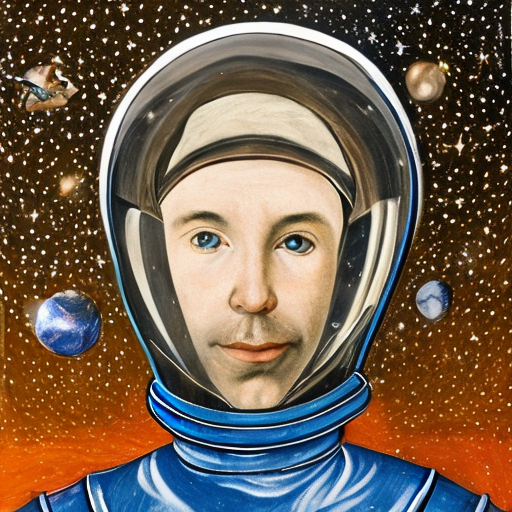

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(42)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image

O outro parâmetro na chamada do pipeline é `guidance_scale`. É uma forma de aumentar a aderência ao sinal condicional que neste caso é o texto, bem como a qualidade geral da amostra. Em termos simples, a orientação livre do classificador força a geração a combinar melhor com o prompt. Números como `7` ou `8.5` dão bons resultados, se você usar um número muito grande, as imagens podem parecer boas, mas serão menos diversificadas.

Você pode aprender sobre os detalhes técnicos deste parâmetro na [última seção](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) deste notebook.

Para gerar várias imagens para o mesmo prompt, basta usarmos uma lista com o mesmo prompt repetido várias vezes. Enviaremos a lista para o pipeline em vez da string que usamos antes.


Vamos primeiro escrever uma função auxiliar para exibir uma grade de imagens. Basta executar a célula a seguir para criar a função `image_grid`.

In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Agora, podemos gerar uma imagem de grade depois de executar o pipeline com uma lista de 3 prompts.

  0%|          | 0/50 [00:00<?, ?it/s]

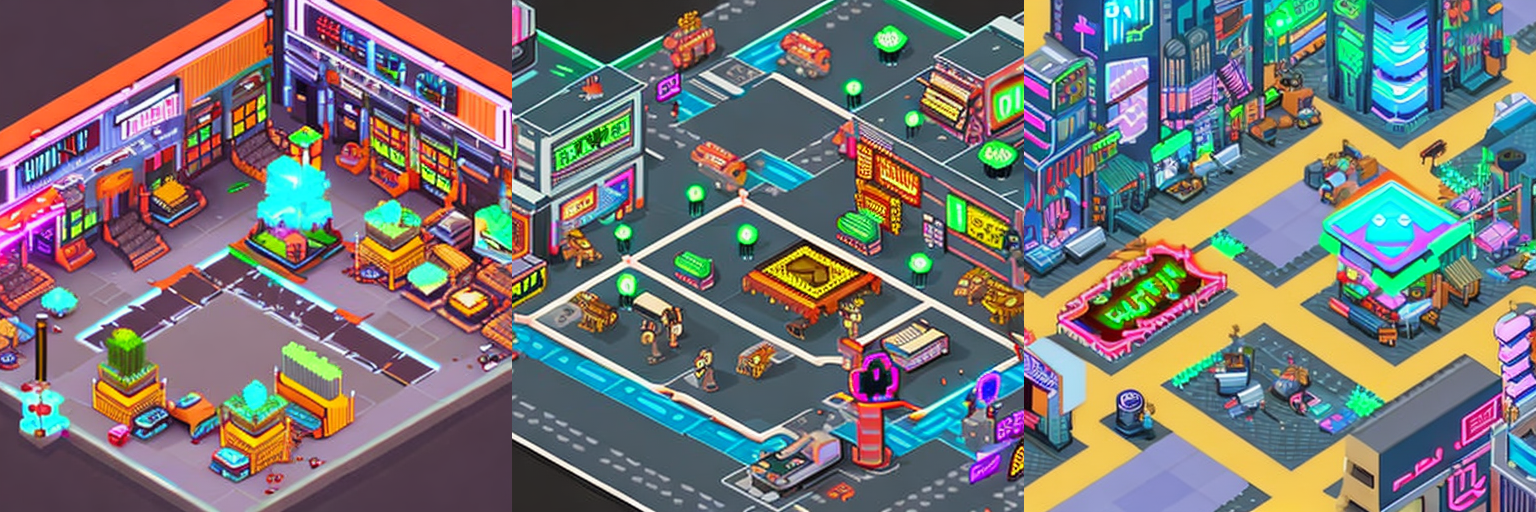

In [ ]:
num_images = 3
prompt = ["Isometric digital art on 8 bits video game style of a cyberpunk town with neon signs, a big market square and townsfolk."] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

E aqui está como gerar uma grade de imagens `n × m`.

In [ ]:
num_cols = 3
num_rows = 4

prompt = ["Isometric digital art on 8 bits video game style of a cyberpunk town with neon signs, a big market square and townsfolk."] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

### Gerando imagens não quadradas

Stable Diffusion produz imagens de `512 × 512` pixels por padrão. Mas é muito fácil substituir o padrão usando os argumentos de `altura` e `largura`, para que você possa criar imagens retangulares nas proporções retrato ou paisagem.

Estas são algumas recomendações para escolher bons tamanhos de imagem:

- Certifique-se de que a `altura` e a `largura` sejam múltiplos de `8`.
- Ir abaixo de 512 pode resultar em imagens de qualidade inferior.
- Ultrapassar 512 em ambas as direções repetirá as áreas da imagem (perde-se a coerência global).
- A melhor maneira de criar imagens não quadradas é usar `512` em uma dimensão e um valor maior que o da outra.




  0%|          | 0/50 [00:00<?, ?it/s]

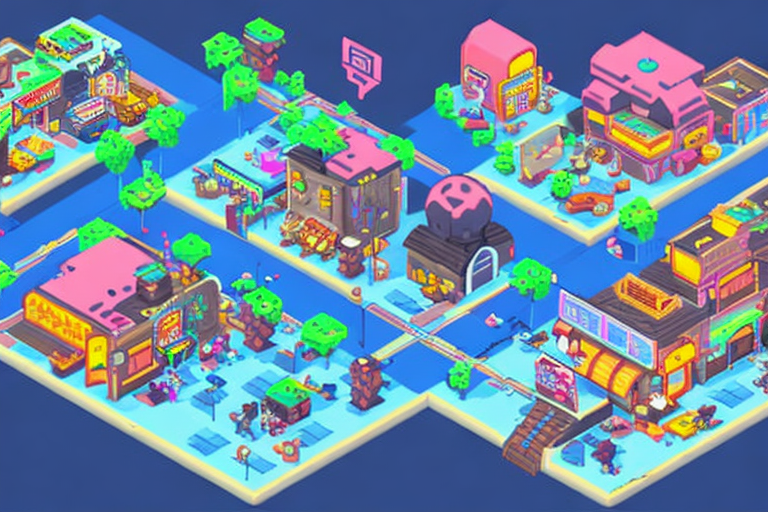

  0%|          | 0/50 [00:00<?, ?it/s]

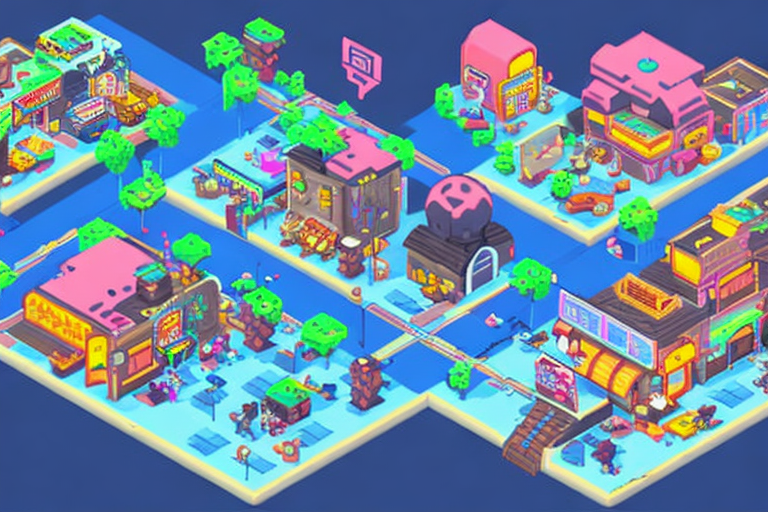

In [ ]:
prompt = "Isometric digital art on 8 bits video game style of a cyberpunk town with neon signs, a big market square and townsfolk."

image = pipe(prompt, height=512, width=768).images[0]
image

## 2. O que é Stable Diffusion?

Agora, vamos para a parte teórica de Stable Diffusion 👩‍🎓.

Stable Diffusion é baseada em um tipo particular de modelo de difusão chamado Difusão Latente, proposto no paper [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



Os modelos gerais de difusão são sistemas de aprendizado de máquina treinados para *remover o ruído* gaussiano aleatório passo a passo (denoising), para chegar a uma amostra de interesse, como uma *imagem*. Para uma visão geral mais detalhada de como eles funcionam, verifique [esse colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Os modelos de difusão demonstraram alcançar resultados de ponta para gerar dados de imagem. Mas uma desvantagem dos modelos de difusão é que o processo de redução de ruído reverso é lento. Além disso, esses modelos consomem muita memória porque operam em espaço de pixel, o que se torna excessivamente caro ao gerar imagens de alta resolução. Portanto, é um desafio treinar esses modelos e também usá-los para inferência.



<br>

A difusão latente pode reduzir a memória e a complexidade computacional aplicando o processo de difusão em um espaço _latente_ dimensional inferior, em vez de usar o espaço de pixel real. Esta é a principal diferença entre os modelos de difusão padrão e de difusão latente: **na difusão latente, o modelo é treinado para gerar representações latentes (comprimidas) das imagens.**

Existem três componentes principais na difusão latente.

1. Um codificador automático (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. Um codificador de texto, *por exemplo* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. O Autoencoder (VAE)**

O modelo VAE tem duas partes, um codificador e um decodificador. O codificador é usado para converter a imagem em uma representação latente de baixa dimensão, que servirá como entrada para o modelo *U-Net*.
O decodificador, ao contrário, transforma a representação latente de volta em imagem.

  Durante o _treinamento_ de difusão latente, o codificador é usado para obter as representações latentes (_latentes_) das imagens para o processo de difusão direta, que aplica cada vez mais ruído a cada etapa. Durante a _inferência_, os latentes sem ruído gerados pelo processo de difusão reversa são convertidos novamente em imagens usando o decodificador VAE. Como veremos durante a inferência, **precisamos apenas do decodificador VAE**.

**2. A U-Net**

A U-Net possui uma parte codificadora e uma parte decodificadora, ambas compostas por blocos ResNet.

O codificador comprime uma representação de imagem em uma representação de imagem de resolução mais baixa e o decodificador decodifica a representação de imagem de resolução mais baixa de volta para a representação de imagem original de resolução mais alta que é supostamente menos ruidosa.

Mais especificamente, a saída U-Net prevê o ruído residual que pode ser usado para calcular a representação de imagem sem ruído prevista.

Para evitar que o U-Net perca informações importantes durante o downsampling, geralmente são adicionadas conexões de atalho entre os ResNets de downsampling do codificador e os ResNets de upsampling do decodificador.

Além disso, a difusão estável U-Net é capaz de condicionar sua saída em incorporações de texto por meio de camadas de atenção cruzada. As camadas de atenção cruzada são adicionadas à parte do codificador e do decodificador da U-Net, geralmente entre os blocos ResNet.

**3. O codificador de texto**

O codificador de texto é responsável por transformar o prompt de entrada, *por exemplo* "Um astronauta andando a cavalo" em um espaço de incorporação que pode ser entendido pela U-Net. Geralmente é um codificador *baseado em transformador* simples que mapeia uma sequência de tokens de entrada para uma sequência de incorporações de texto latentes.

Inspirado por [Imagen](https://imagen.research.google/), Stable Diffusion **não** treina o codificador de texto durante o treinamento e simplesmente usa um codificador de texto já treinado do CLIP, [CLIPTextModel](https:/ /huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Por que stable diffusion é rápida e eficiente?**

Uma vez que a U-Net dos modelos de difusão latente opera em um espaço de baixa dimensão, ela reduz bastante os requisitos de memória e computação em comparação com os modelos de difusão de espaço de pixel. Por exemplo, o autoencoder usado em Stable Diffusion tem um fator de redução de 8. Isso significa que uma imagem de forma `(3, 512, 512)` torna-se `(3, 64, 64)` no espaço latente, o que requer `8 × 8 = 64` vezes menos memória.

É por isso que é possível gerar imagens `512 × 512` tão rapidamente, mesmo em GPUs Colab de 16 GB!

**Stable Diffusion durante inferência**

Juntando tudo, vamos agora dar uma olhada mais de perto em como o modelo funciona na inferência ilustrando o fluxo lógico.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

O modelo de stable diffusion usa uma semente latente e um prompt de texto como entrada. A semente latente é então usada para gerar representações aleatórias de imagens latentes de tamanho $64 \times 64$ onde, conforme o prompt de texto, é transformado em incorporações de texto de tamanho $77 \times 768$ por meio do codificador de texto do CLIP.

Em seguida, o U-Net iterativamente *reduz* as representações de imagens latentes aleatórias enquanto é condicionado nas incorporações de texto. A saída do U-Net, sendo o ruído residual, é usada para calcular uma representação de imagem latente sem ruído por meio de um algoritmo de escalonamento. Muitos algoritmos de agendadores diferentes podem ser usados para esse cálculo, cada um com seus prós e contras. Para difusão estável, recomendamos o uso de um dos seguintes:

- [Agendador PNDM](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (usado por padrão).
- [Agendador K-LMS](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py).
- [Agendador discreto Heun](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_heun_discrete.py).
- [Agendador de várias etapas do DPM Solver](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_dpmsolver_multistep.py). Este agendador é capaz de alcançar grande qualidade em menos passos. Você pode tentar com 25 em vez do padrão 50!

A teoria sobre como a função do algoritmo do agendador está fora do escopo deste notebook, mas, em suma, deve-se lembrar que eles calculam a representação de imagem sem ruído prevista a partir da representação de ruído anterior e do resíduo de ruído previsto.
Para obter mais informações, recomendamos consultar [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

O processo de *redução de ruído* é repetido *em torno de* 50 vezes para recuperar passo a passo as melhores representações de imagens latentes.
Depois de concluída, a representação da imagem latente é decodificada pela parte do decodificador do codificador automático variacional.